# Solving a QUBO using QOAO ansatz in qiskit

In [1]:
import sys
sys.path.append('../')
from src.loaddata import LoadData
from src.qubo import Qubo

In [2]:
# LoadData does all the file loading
ld = LoadData()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld)

In [3]:
from qiskit_algorithms.utils import algorithm_globals

qubo, ising_ham = q.qubo_hamiltonian_pairs[0] # use the first slice as an example to solve
num_qubits = len(qubo)

In [4]:
#QAOA approach

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator, Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')


In [5]:
# QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

from qiskit.circuit.library import TwoLocal
# TwoLocal ansatz circuit
twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

def cost_func(params, ansatz, ising_ham, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    result = estimator.run(ansatz, ising_ham, parameter_values=params).result()
    cost = result.values[0]
    return cost


estimator = Estimator(options={"shots": int(1e4)})
sampler = Sampler(options={"shots": int(1e4)})

/Users/farrokhlabib/Documents/github/aquapointer/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


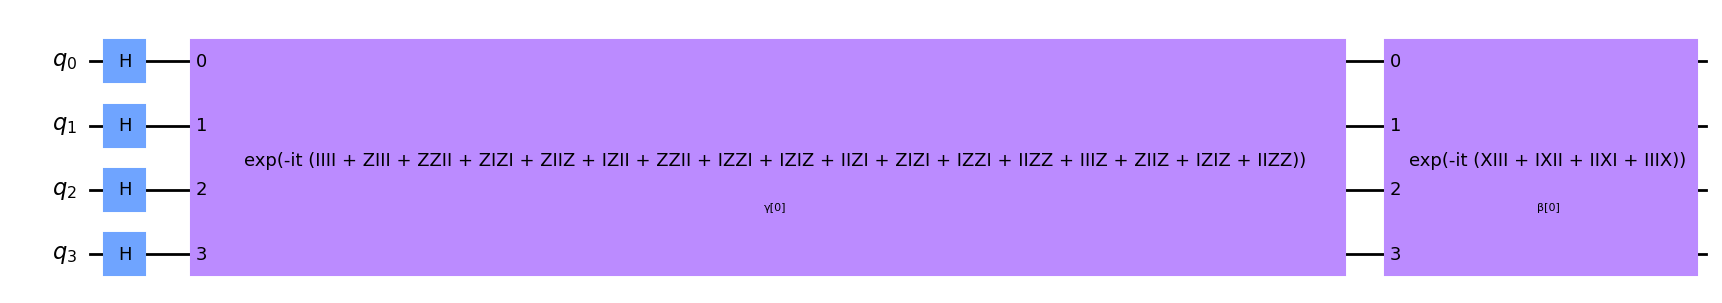

In [23]:
qaoa_ansatz.decompose(reps=1).draw("mpl")

OrderedDict([('rzz', 12), ('u2', 4), ('rz', 4), ('rx', 4)]) 16


/Users/farrokhlabib/Documents/github/aquapointer/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


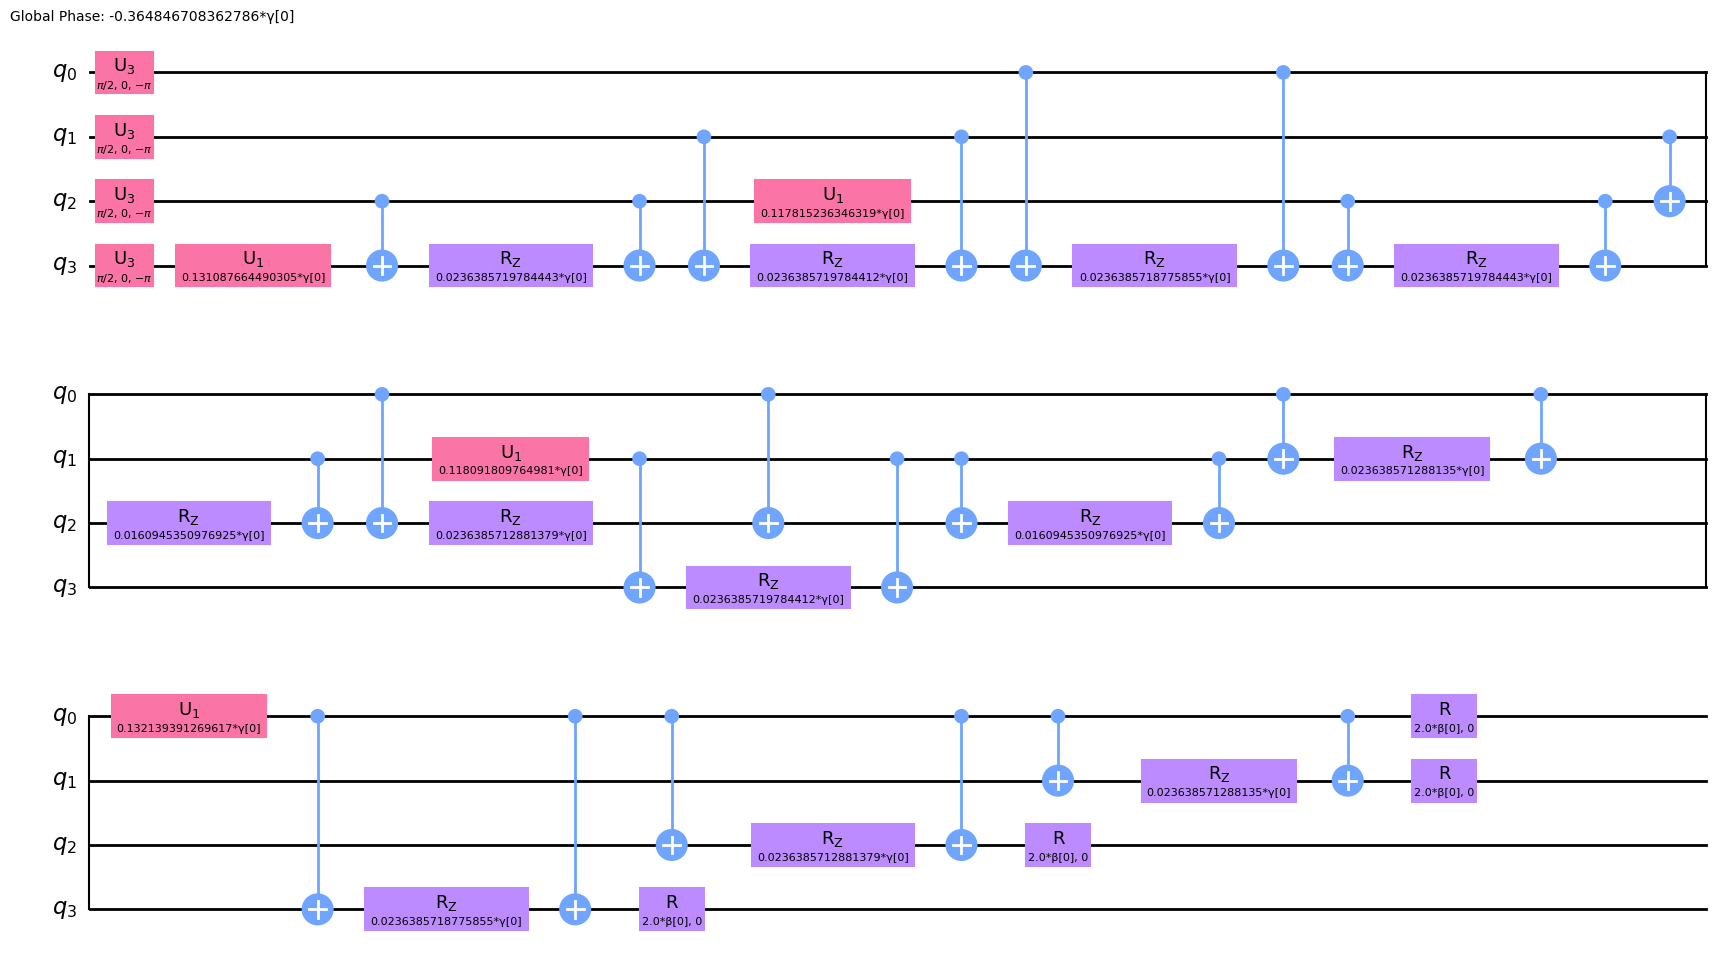

In [24]:
from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
qaoa_ansatz_compiled = transpile(qaoa_ansatz, backend)
print(qaoa_ansatz_compiled.count_ops(), qaoa_ansatz_compiled.depth())

qaoa_ansatz_compiled.decompose(reps=1).draw("mpl")

OrderedDict([('ry', 8), ('cx', 3)]) 5


/Users/farrokhlabib/Documents/github/aquapointer/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


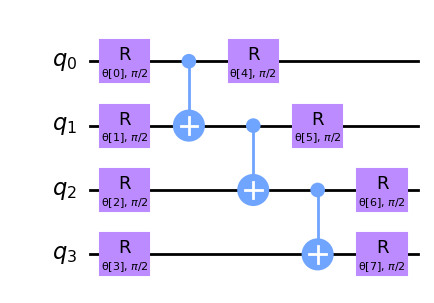

In [41]:
twolocal_ansatz_compiled = transpile(twolocal_ansatz, backend)
print(twolocal_ansatz_compiled.count_ops(), twolocal_ansatz_compiled.depth())
twolocal_ansatz_compiled.decompose(reps=1).draw("mpl")

In [12]:
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
x0 = beta+gamma
# x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
res = minimize(cost_func, x0, args=(qaoa_ansatz, ising_ham, estimator), method="COBYLA")
res

     fun: 0.047685202225186685
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 36
  status: 1
 success: True
       x: array([2.55853323, 2.47302148])

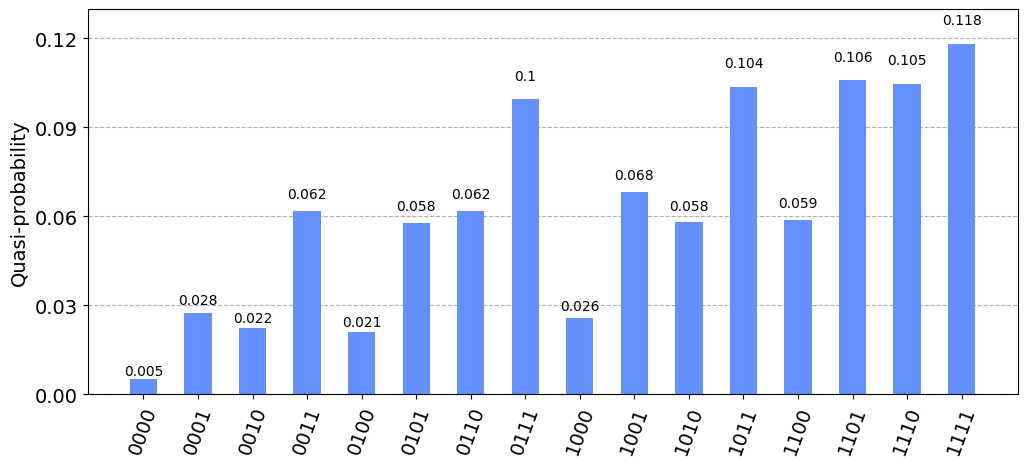

In [28]:
# Assign solution parameters to ansatz
qc = qaoa_ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

plot_distribution(samp_dist.binary_probabilities(), figsize=(12, 5))

In [29]:
# classical brute-force solution
sol, ref_value = q.find_optimum(qubo=qubo)
sol, ref_value

([1, 0, 0, 0], -0.010743767178636635)

In [30]:
samp_dist_binary=samp_dist.binary_probabilities()
# for key in samp_dist.keys():
#     samp_dist_binary[tuple(q._bitfield(key, len(qubo)))]=samp_dist[key]

solutions_list=[]
prob_energy = []
for key in samp_dist_binary.keys():
    reverse_key = key[::-1]
    keynot = [(int(b)+1)%2 for b in reverse_key]
    solutions_list.append([tuple(keynot), samp_dist_binary[key], q.ising_energy(keynot, qubo)])
    prob_energy.append([samp_dist_binary[key], q.ising_energy(keynot, qubo)])

prob_energy = np.array(prob_energy)
avg_energy = np.sum([x[0]*x[1] for x in prob_energy])
avg_energy

0.04739906593295764

In [31]:
# Get the indices that would sort the last element in each row
indices = np.argsort(prob_energy[:, -1])

# Use the indices to rearrange the rows in the original array
sorted_arr = prob_energy[indices]
sorted_arr

array([[ 0.1047    , -0.01074377],
       [ 0.0997    , -0.00969204],
       [ 0.1058    , -0.00892812],
       [ 0.1037    , -0.00865155],
       [ 0.118     ,  0.        ],
       [ 0.0681    ,  0.04679847],
       [ 0.0617    ,  0.07411848],
       [ 0.0587    ,  0.0748824 ],
       [ 0.058     ,  0.07515897],
       [ 0.0579    ,  0.07593413],
       [ 0.0617    ,  0.0762107 ],
       [ 0.0258    ,  0.22516328],
       [ 0.0275    ,  0.22621501],
       [ 0.021     ,  0.25429894],
       [ 0.0224    ,  0.25457551],
       [ 0.0053    ,  0.4991341 ]])

# using vqe.py module

In [6]:
from src.vqe import VQE

# vqe with twolocal ansatz
vqe = VQE(ansatz=twolocal_ansatz, ising_ham=ising_ham, estimator=estimator, sampler=sampler)

In [7]:
vqe.iterate(10)
vqe.average_energy(params=vqe.params, qubo=qubo)

-0.010510475161139368

In [8]:
#vqe with qaoa ansatz
vqe_qaoa = VQE(ansatz=qaoa_ansatz, ising_ham=ising_ham, estimator=estimator, sampler=sampler)

In [13]:
params = beta+gamma

In [14]:
vqe_qaoa.params = params
vqe_qaoa.iterate(10)
vqe_qaoa.average_energy(params=vqe_qaoa.params, qubo=qubo)

0.007834221386567353